## Abbildung Poster 2024

In [1]:
from src import devices as blab  # <- crucial import for using the B-Lab functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
from scipy import signal
from scipy.signal import find_peaks
from scipy import special
from scipy import optimize
from scipy.optimize import curve_fit, OptimizeWarning
import warnings 

In [2]:
def rgb_to_hex(rgb):# hier kann ich direkt die Farben aus Inkscape eintragen und bekommen ienen colorcode mit #123456 raus
    """
    Convert an RGB color value to a hex color code.

    :param rgb: A tuple of red, green, and blue (each in the range 0-255)
    :return: A string representing the hex color code
    """
    r, g, b = rgb
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

In [3]:
def apply_filters(df: pd.DataFrame, filters: dict) -> pd.DataFrame:
    filtered_df = df.copy()

    for name, value in filters.items():
        filtered_df = filtered_df[filtered_df[name] == value]

    return filtered_df 

def maxima(data_in: pd.DataFrame, column_x:str = 'Temperature (C)', column_y:str = 'Abs'):
    df = data_in.sort_values(column_x)
    derivative_1 = df[column_y].to_numpy()
    
    peaks, _ = signal.find_peaks(derivative_1, height=0, width =2)
    plt.plot(df[column_x],derivative_1)
    plt.plot(df.iloc[peaks, 0], derivative_1[peaks], "x")
    plt.xlabel("temperature in °C")
    plt.ylabel("dAbs_dT")
    #plt.plot(np.zeros_like(x), "--", color="gray")
    plt.show()
    temp_1 = df.iloc[peaks, 0]
    print(f'Maximum bei  {temp_1}')#+ df.iloc[peaks, 0]) #+ ', y = '+derivative_1[peaks])
    return temp_1

def skewed_gaussian(x, a, mu, sigma, gamma):
    return a/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))*(1+special.erf(gamma*(x-mu)/(sigma*np.sqrt(2))))
    
def sum_of_skewed_gaussians(x, *params):
    num_skewed_gaussians = int(len(params) / 4)
    y = np.zeros(len(x))
    for i in range(num_skewed_gaussians):
        a = params[i*4]
        mu = params[i*4+1]
        sigma = params[i*4+2]
        gamma = params[i*4+3]
        y += skewed_gaussian(x, a, mu, sigma, gamma)
    return y

def find_max_s(df_input, index_name:str = 'CurveIndex', curve_name:str = 'Name', first_deri_name = 'dAbs/dT', column_x:str = 'Temperature (C)', column_y:str = 'Normalized Abs', estimated_peak_number: int = 1, fit_bounds_gauss: tuple = (0, 100), threshould = 0.02):
    df = df_input.copy().sort_values(column_x)
    df[first_deri_name] = np.gradient(df[column_y], df[column_x])
    curve_index = df_input[index_name].unique()[0]
    df2 = df.loc[((df[column_x] >= fit_bounds_gauss[0]) & (df[column_x] <= fit_bounds_gauss[1])), :]
    # Convert DataFrame to numpy arrays
    xdata = np.array(df2[column_x])
    ydata = np.array(df2[first_deri_name])
    #ydata = np.gradient(df[column_y], df[column_x])


    # Define the initial parameter values for the Gaussian function
    num_gaussians = estimated_peak_number
    p0 = np.zeros(num_gaussians * 4)
    bounds_lower = np.zeros(num_gaussians * 4)
    bounds_upper = np.zeros(num_gaussians * 4)
    for i in range(num_gaussians):
        p0[i*4] = np.max(ydata) / num_gaussians
        bounds_lower[i*4] = 0#0.02
        bounds_upper[i*4] = 10
        p0[i*4+1] = 50
        bounds_lower[i*4+1] = 0
        bounds_upper[i*4+1] = 100
        p0[i*4+2] = np.std(xdata) / 2
        bounds_lower[i*4+2] = 0
        bounds_upper[i*4+2] = 100
        p0[i*4+3] = 0
        bounds_lower[i*4+3] = -100
        bounds_upper[i*4+3] = 100
    # Fit the sum of Gaussian functions to the data
    print(bounds_lower, bounds_upper)
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("error")
            try:
                popt, pcov = curve_fit(sum_of_skewed_gaussians, xdata, ydata, p0=p0, bounds= (bounds_lower, bounds_upper))
            except ValueError as error:
                # If ValueError occurs, retry without bounds
                print("An error occurred:", str(error ))
                print("Retrying without bounds...")
                popt, pcov = curve_fit(sum_of_skewed_gaussians, xdata, ydata, p0=p0)

    except (RuntimeError, OptimizeWarning):
        df_out = pd.DataFrame({
            index_name: curve_index,
    #        'Environment': df['Environment'].unique()[0],
          #  'Concentration': df['Concentration'].unique()[0],
         #   'Ion': df['Ion'].unique()[0],
        #    'Ramp_Type': df['Ramp_Type'].unique()[0],
             curve_name: df[curve_name].unique()[0],
            'a_vals': [np.nan],
            'a_std_devs': [np.nan],
            'a_ci_low': [np.nan],
            'a_ci_high': [np.nan],
            'mu_vals': [np.nan],
            'mu_std_devs': [np.nan],
            'mu_ci_low': [np.nan],
            'mu_ci_high': [np.nan],
            'sigma_vals': [np.nan],
            'sigma_std_devs': [np.nan],
            'sigma_ci_low': [np.nan],
            'sigma_ci_high': [np.nan],
            'gamma': [np.nan],
            'R2': [np.nan],
            'SSR': [np.nan],
            'SST': [np.nan]
            })
        
        print(f'Curve with index {curve_index} failed')
        return df, df_out
    print(popt)
    # Extract the maximum values, standard deviations, and confidence intervals from the Gaussian fit
    num_params = len(popt)
    max_vals = []
    std_devs = []
    ci_low = []
    ci_high = []
    alpha = 0.05
    t_val = stats.t.ppf(1 - alpha/2, len(xdata) - num_params)
    x_max_vals = []
    x_ci_low = []
    x_ci_high = []
    sigma_vals = []
    sigma_ci_low = []
    sigma_ci_high = []
    gamma = []
    '''
    for i in range(num_params // 3):
        a = popt[i*3]
        x0 = popt[i*3+1]
        sigma = popt[i*3+2]
        max_vals.append(a)
        std_devs.append(np.sqrt(np.diag(pcov)[i*3]))
        a_std_dev = std_devs[i, -3]
        ci_low.append(a - t_val * std_devs[-1])
        ci_high.append(a + t_val * std_devs[-1])
        x_max_vals.append(x0)
        x_std_dev = std_devs[i, -2]#std_devs[-1] / abs(gaussian(x0, a, x0, sigma))
        x_ci_low.append(x0 - t_val * x_std_dev)
        x_ci_high.append(x0 + t_val * x_std_dev)
        sigma_vals.append(sigma)
        sigma_std_dev = std_devs[i, -1]#std_devs[-1] / abs(gaussian(x0, a, x0, sigma))
        sigma_ci_low.append(sigma - t_val * x_std_dev)
        sigma_ci_high.append(sigma + t_val * x_std_dev)
    '''
    for i in range(num_params // 4):
        a = popt[i*4]
        x0 = popt[i*4+1]
        sigma = popt[i*4+2]
        gamma = popt[i*4+3]
        
        max_vals.append(a)
        std_devs.append(np.sqrt(np.diag(pcov)[i*3]))
        a_std_devs = std_devs[-1]
        ci_low.append(a - t_val * std_devs[-1])
        ci_high.append(a + t_val * std_devs[-1])
        x_max_vals.append(x0)
        x_std_dev = std_devs[-1]#std_devs[-1] / abs(gaussian(x0, a, x0, sigma))
        x_ci_low.append(x0 - t_val * x_std_dev)
        x_ci_high.append(x0 + t_val * x_std_dev)
        sigma_vals.append(sigma)
        sigma_std_dev = std_devs[-1]#std_devs[-1] / abs(gaussian(x0, a, x0, sigma))
        sigma_ci_low.append(sigma - t_val * x_std_dev)
        sigma_ci_high.append(sigma + t_val * x_std_dev)
    
    # Calculate additional statistics
    yhat = sum_of_skewed_gaussians(df[column_x], *popt)
    res = (df[first_deri_name] - yhat)
    SSR = np.sum(res ** 2)
    SST = np.sum((ydata - np.mean(ydata)) ** 2)
    R2 = 1 - SSR / SST

    df['Gauss Fit'] = yhat
    df['Residuals'] = res
    # Create output DataFrame
    df_out = pd.DataFrame({
        index_name: curve_index,
        #'Environment': df['Environment'].unique()[0],
        #'Concentration': df['Concentration'].unique()[0],
        #'Ion': df['Ion'].unique()[0],
      #  'Ramp_Type': df['Ramp_Type'].unique()[0],
        curve_name: df[curve_name].unique()[0],
        'a_vals': max_vals,
        'a_std_devs': a_std_devs,
        'a_ci_low': ci_low,
        'a_ci_high': ci_high,
        'mu_vals': x_max_vals,
        'mu_std_devs': x_std_dev,
        'mu_ci_low': x_ci_low,
        'mu_ci_high': x_ci_high,
        'sigma_vals': sigma_vals,
        'sigma_std_devs': sigma_std_dev,
        'sigma_ci_low': sigma_ci_low,
        'sigma_ci_high': sigma_ci_high,
        'gamma': gamma,
        'R2': R2,
        'SSR': SSR,
        'SST': SST
        })
    
    fit_max = pd.DataFrame(maxima(df , column_x = column_x , column_y='Gauss Fit'))
    fit_max[index_name] = curve_index
    fit_max[curve_name] = df[curve_name].unique()[0]
    
    return df, df_out, fit_max

def normalize_Abs_min_max(df: pd.DataFrame, filter_columns: list = ['Run', 'Name'], column_to_normalize: str = 'Absorbance')-> pd.DataFrame: 
    df[f'Normalized {column_to_normalize}'] = df.groupby(filter_columns)[column_to_normalize].transform(normalize_min_max)
    return df

def normalize_min_max(x):
    return (x - x.min()) / (x.max() - x.min())

def normalize_bounds(x, lower, upper):
    return (x - lower) / (upper - lower)

def normalize_data(df: pd.DataFrame, filter_columns: list = ['Run', 'Name'], column_to_normalize: str = 'Absorbance', column_bounds: str = 'Temperature (°C)', normalize_to:tuple = None):
    if normalize_to == None:
        return print('Bitte bounds angeben')
    closests = [0,0]
    for i in [0,1]:
        df_closest = df.iloc[(df[column_bounds]-normalize_to[i]).abs().argsort()[:1]]
        closests[i] = df_closest[column_to_normalize].tolist()[0]
    df[f'Normalized {column_to_normalize}'] = normalize_bounds(df[column_to_normalize], closests[0], closests[1])
    return df

# fit bei 2 maxima
def equation_molecularity_1(T, DH_1,DH_2, Tm_1, Tm_2, m1, n1, m2, n2, m3, n3):
    R = 8.31446261815324   # m^3* Pa * K^−1 * mol^−1
    x_1 = DH_1/R*(1/(T+273.15) - 1/(Tm_1+273.15))
    x_2 = DH_1/R*(1/(T+273.15) - 1/(Tm_2+273.15))
    theta_1 = 1 / (1 + np.exp(x_1))
    theta_2 = 1 - (2 / (1 + (1+8*np.exp(-x_2))**0.5))
    return ((m1 * (T+273.15) + n1)*theta_1 + (m2 * (T+273.15) + n2)*(1 - theta_1) + (m2 * (T+273.15) + n2)*theta_2 + (m3 * (T+273.15) + n3)*(1 - theta_2) )

In [4]:
def add_names_from_file(file_path, df):
    names = []
    with open(file_path, 'r', encoding='UTF-8') as file:
        firstline = file.readlines()[0]
        firstline = firstline.strip('\n')
        meta = firstline.split(',')
        meta = list(filter(None, meta))
        for name in meta:
            names.append(name)

    measure = 1
    for i, name in enumerate(names):
        df.loc[df['Measurement'] == measure, "Name"] = name
        measure += 1

    return df



data = pd.read_csv('Export Data 2023-07-26_RNA_melting_MgCl2.csv', header=1)
data2 = pd.read_csv('Export Data 2023-09-20_RNA_melting_KCl.csv', header=1)
new_df = pd.concat([pd.DataFrame({"Temperature (C)": data[t_col], "Abs": data[abs_col], "Measurement": i + 1})
                            for i, (t_col, abs_col) in enumerate(zip(data.filter(like="Temperature"), data.filter(like="Abs")))],
                            ignore_index=True)

fertig = add_names_from_file('Export Data 2023-07-26_RNA_melting_MgCl2.csv', new_df.dropna())
fertig2 = add_names_from_file('Export Data 2023-09-20_RNA_melting_KCl.csv', new_df.dropna())
fertig

,Temperature (C),Abs,Measurement,Name
0,90.000000,0.353807,1,5 mM MgCl2_260.00nm_90.0-21.0C
1,89.000000,0.355598,1,5 mM MgCl2_260.00nm_90.0-21.0C
2,88.000000,0.356998,1,5 mM MgCl2_260.00nm_90.0-21.0C
3,87.000000,0.357666,1,5 mM MgCl2_260.00nm_90.0-21.0C
4,86.000000,0.357527,1,5 mM MgCl2_260.00nm_90.0-21.0C
...,...,...,...,...
2235,86.000000,0.034180,32,0 mM MgCl2_400.00nm_21.0-90.0C_R1
2236,87.000000,0.034178,32,0 mM MgCl2_400.00nm_21.0-90.0C_R1
2237,88.000000,0.034176,32,0 mM MgCl2_400.00nm_21.0-90.0C_R1
2238,89.000000,0.034159,32,0 mM MgCl2_400.00nm_21.0-90.0C_R1


In [5]:
grouped_daten = fertig.groupby("Measurement")
datafrappes = []


for number, measure in grouped_daten:
    min_val = min(measure["Abs"])
    max_val = max(measure["Abs"])
    measure["norm_Abs"] = (measure["Abs"] - min_val) / (max_val - min_val)
    measure["dabs_dt"] = np.gradient(measure["norm_Abs"], measure["Temperature (C)"])
    
    datafrappes.append(measure)

    
prepared_data = pd.concat(datafrappes)
prepared_data
prepared_data.to_csv('Mg_prepared_data.csv', index=False) 

grouped_daten2 = fertig2.groupby("Measurement")
datafrappes2 = []


for number, measure in grouped_daten2:
    min_val = min(measure["Abs"])
    max_val = max(measure["Abs"])
    measure["norm_Abs"] = (measure["Abs"] - min_val) / (max_val - min_val)
    measure["dabs_dt"] = np.gradient(measure["norm_Abs"], measure["Temperature (C)"])
    
    datafrappes2.append(measure)

    
prepared_data2 = pd.concat(datafrappes2)
prepared_data2
prepared_data.to_csv('K_prepared_data.csv', index=False)

In [6]:
df_5mM_260_90 = prepared_data[prepared_data["Measurement"] == 1]
df_5mM_260_21 = prepared_data[prepared_data["Measurement"] == 2]
df_5mM_260_90_2 = prepared_data[prepared_data["Measurement"] == 3]
df_5mM_260_21_2 = prepared_data[prepared_data["Measurement"] == 4]

df_21mM_KCl_260_90 = prepared_data[prepared_data["Measurement"] == 5]
df_21mM_KCl_260_21 = prepared_data[prepared_data["Measurement"] == 6]
df_21mM_KCl_260_90_2 = prepared_data[prepared_data["Measurement"] == 7]
df_21mM_KCl_260_21_2 = prepared_data[prepared_data["Measurement"] == 8]

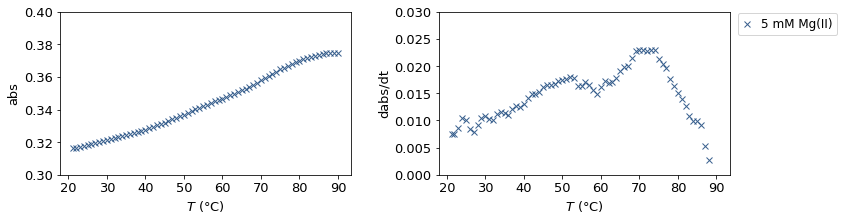

In [7]:
#f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4), sharex=False, sharey=False, squeeze=False)
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), sharex=False, sharey=False, squeeze=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
temps = 8
palette = plt.get_cmap('Accent',temps)
# draw plot for the two plots
ax[0,0].scatter(df_5mM_260_90_2["Temperature (C)"], df_5mM_260_90_2["Abs"], marker='x', color=rgb_to_hex((36, 79, 130)), linewidth=1, alpha=0.9, label='5 mM Mg(II)')

ax[0,1].scatter(df_5mM_260_90_2["Temperature (C)"], df_5mM_260_90_2["dabs_dt"], marker='x', color=rgb_to_hex((36, 79, 130)), linewidth=1, alpha=0.9, label='5 mM Mg(II)')

ax[0,0].set_ylim([0.3,0.4])
ax[0,1].set_ylim([0.0,0.03])
ax[0,0].tick_params(axis='both', labelsize=13)
ax[0,1].tick_params(axis='both', labelsize=13)
ax[0,0].locator_params(axis="both", nbins=10)
ax[0,1].locator_params(axis="both", nbins=10)
ax[0,0].set_xlabel('$T$ (°C)', fontsize = 13)
ax[0,1].set_xlabel('$T$ (°C)', fontsize = 13)
ax[0,0].set_ylabel("abs", fontsize = 13)
ax[0,1].set_ylabel("dabs/dt", fontsize = 13)
plt.legend(frameon=True, handlelength=0.75, fontsize='large', loc='upper right', bbox_to_anchor=(1.39, 1.03))
plt.savefig("melting_poster.png", dpi=600, bbox_inches="tight")
plt.savefig("melting_poster.svg", dpi=600, bbox_inches="tight")
plt.show()

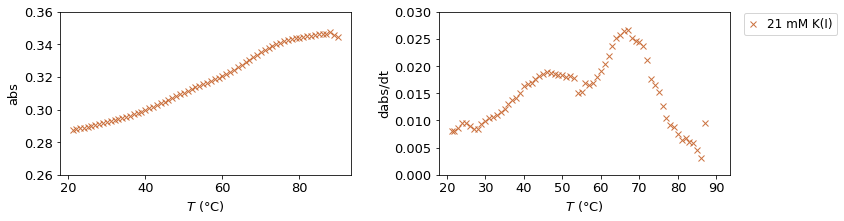

In [8]:
#f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4), sharex=False, sharey=False, squeeze=False)
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), sharex=False, sharey=False, squeeze=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
temps = 8
palette = plt.get_cmap('Accent',temps)
# draw plot for the two plots
ax[0,0].scatter(df_21mM_KCl_260_90["Temperature (C)"], df_21mM_KCl_260_90["Abs"], marker='x', color=rgb_to_hex((198, 99, 43)), linewidth=1, alpha=0.9, label='21 mM K(I)')

ax[0,1].scatter(df_21mM_KCl_260_90["Temperature (C)"], df_21mM_KCl_260_90["dabs_dt"], marker='x', color=rgb_to_hex((198, 99, 43)), linewidth=1, alpha=0.9, label='21 mM K(I)')

ax[0,0].set_ylim([0.26,0.36])
ax[0,1].set_ylim([0.0,0.03])
ax[0,0].tick_params(axis='both', labelsize=13)
ax[0,1].tick_params(axis='both', labelsize=13)
ax[0,0].locator_params(axis="both", nbins=5)
ax[0,1].locator_params(axis="both", nbins=10)
ax[0,0].set_xlabel('$T$ (°C)', fontsize = 13)
ax[0,1].set_xlabel('$T$ (°C)', fontsize = 13)
ax[0,0].set_ylabel("abs", fontsize = 13)
ax[0,1].set_ylabel("dabs/dt", fontsize = 13)
plt.legend(frameon=True, handlelength=0.75, fontsize='large', loc='upper right', bbox_to_anchor=(1.39, 1.03))
plt.savefig("K_melting_poster.png", dpi=600, bbox_inches="tight")
plt.savefig("K_melting_poster.svg", dpi=600, bbox_inches="tight")
plt.show()